In [34]:
import tensorflow as tf
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
SEED = 2000


train=pd.read_csv('train_E6oV3lV.csv')
test=pd.read_csv('test_tweets_anuFYb8.csv')

target=train.label
train=train.drop('label',1)
data=train.append(test)
tweet =data.tweet


# pre-processing
print("Text Preprocessing ====>")
data['tweet']=data['tweet'].apply(lambda x: x.lower())
data['tweet']=data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['tweet']=data['tweet'].apply(lambda x: x.replace('user',''))
stop = stopwords.words('english')
data['tweet'] = data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

x = data['tweet'][:len(train)]
y = target

x_train, x_validation_and_test , y_train , y_validation_and_test = train_test_split(x, y,test_size=.3,random_state= SEED)

x_validation , x_test , y_validation , y_test = train_test_split(x_validation_and_test,y_validation_and_test,test_size=0.5,random_state=SEED)


print("Train set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_train),(len(x_train[y_train==0])/(len(x_train)*1.))*100,
                                                                                          (len(x_train[y_train == 1]) / (len(x_train) * 1.)) * 100))



print("Validation set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_validation),(len(x_validation[y_validation==0])/(len(x_validation)*1.))*100,
                                                                                          (len(x_validation[y_validation == 1]) / (len(x_validation) * 1.)) * 100))




print("Test set has total {0} entries with {1:.2f} % positive, {2:.2f}% negative".format(len(x_test),(len(x_test[y_test==0])/(len(x_test)*1.))*100,
                                                                                          (len(x_test[y_test == 1]) / (len(x_test) * 1.)) * 100))







Text Preprocessing ====>
Train set has total 22373 entries with 92.93 % positive, 7.07% negative
Validation set has total 4794 entries with 92.89 % positive, 7.11% negative
Test set has total 4795 entries with 93.33 % positive, 6.67% negative


Text(0.5,0,'$\\chi^2$')

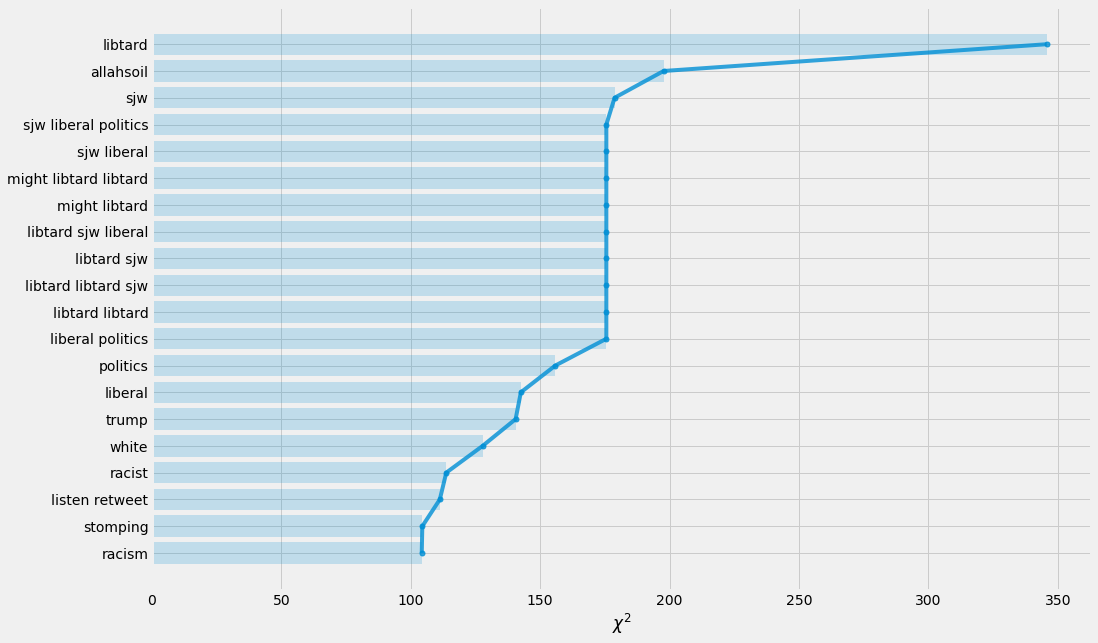

In [35]:
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))

x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [36]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features
chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features
chi2 feature selection evaluation calculated for 50000 features
chi2 feature selection evaluation calculated for 60000 features
chi2 feature selection evaluation calculated for 70000 features
chi2 feature selection evaluation calculated for 80000 features
chi2 feature selection evaluation calculated for 90000 features


In [41]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer, n_features=n_features, stop_words=None, ngram_range=(1,1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 92.89%
accuracy score: 94.64%
model is 1.75% more accurate than null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 92.89%
accuracy score: 94.56%
model is 1.67% more accurate than null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 92.89%
accuracy score: 94.53%
model is 1.65% more accurate than null accuracy
train and test time: 0.44s
--------------------------------------------------------------------------------
Validation result f

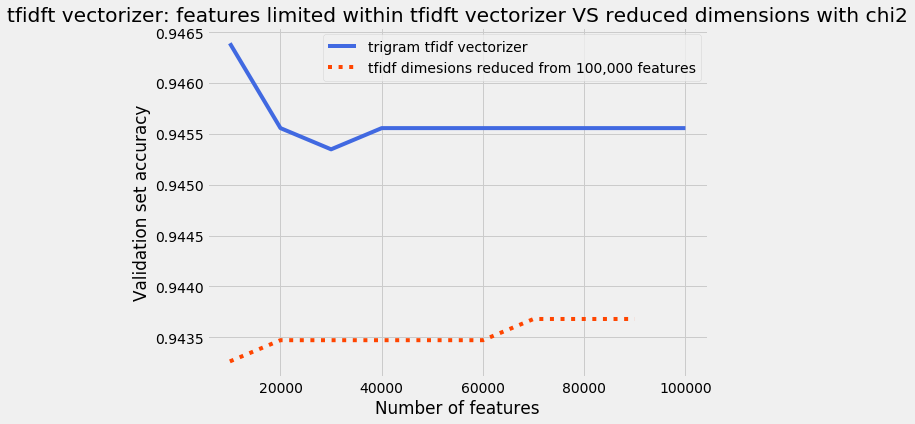

In [46]:
nfeatures_plot_tgt=pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,100000,10000), ch2_result,label='tfidf dimesions reduced from 100,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()